markdown
## Task 1: Implementation of ANN

In this section, I have developed a neural network architecture tailored for classifying breast cancer occurrences based on a feature vector containing 30 features. The architecture comprises an input layer, accommodating the 30 features, a hidden layer with 5 neurons, and an output layer with a single neuron, providing the classification prediction whether a patient has breast cancer or not.

To mitigate potential numerical instability, a stabilized Sigmoid function is employed across all neurons. This adaptation helps circumvent overflow errors that may arise from the Wisconsin dataset's numerical intricacies.

For training backpropagation algorithm has been adopted coupled with mini-batch gradient descent. This approach facilitates efficient convergence towards optimal parameter values by updating weights and biases iteratively. The training process spans 500 epochs, with a modest learning rate of 0.01, ensuring gradual adjustments to model parameters for stable optimization.

Upon completion of training, the neural network's performance is evaluated. The final trained model yields insights into both the error/loss values and the accuracy metrics for both the test and training datasets. These metrics serve as key indicators of the model's efficacy in discerning breast cancer occurrences accurately.

By integrating sophisticated techniques and methodologies, this neural network framework not only addresses numerical challenges inherent in the dataset but also strives to deliver robust and reliable predictive capabilities crucial for cancer diagnosis and prognosis.

### Step 1. Data Preparation:
- Loads the Breast Cancer Wisconsin dataset.
- Splits the dataset into training and testing sets using train_test_split() from scikit-learn.

In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load the breast cancer Wisconsin dataset
data = load_breast_cancer()
x = data.data
y = data.target

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Neural Network Setup:
- Defines the architecture of a neural network with an input layer, a hidden layer with 5 nodes, and an output layer with 1 node.
- Sets hyperparameters like learning rate, number of epochs, and batch size.

In [2]:
# Define the neural network architecture
np.random.seed(0)
input_size = x_train.shape[1]
hidden_size = 5
output_size = 1

# Hyper params
learning_rate = 0.01
epochs = 500
batch_size = 128

### Activation Functions and Loss Functions:
- Defines the sigmoid activation function and its derivative.
- Defines the cross-entropy loss function and its derivative.

In [3]:
# Define the sigmoid activation function and its derivative
def sigmoid(v):
    return 1 / (1 + np.exp(-np.clip(v, -500, 500)))

def sigmoid_derivative(v):
    sig = sigmoid(v)
    sig_prime = sig * (1 - sig)
    return sig_prime

# Loss function and its derivative
def crossEntropy(o, y):
    return (-y * np.log(o) - (1 - y) * np.log(1 - o))

def crossEntropyDeriv(o, y):
    return -(y / o - (1 - y) / (1 - o))

### Initialization:
- Initializes weights and biases for the neural network.

In [4]:
# Initialize weights and biases
w1 = np.random.uniform(-1, 1, (input_size, hidden_size))
b1 = np.zeros((1, hidden_size))
w2 = np.random.uniform(-1, 1, (hidden_size, output_size))
b2 = np.zeros((1, output_size))

### Mini-Batch Creation:
- Creates mini-batches from the training data for mini-batch gradient descent.

In [5]:
# Define function for mini_batch creation
def create_mini_batches(data, batch_size):
    mini_batches = []
    num_samples = data.shape[0]
    num_batches = num_samples // batch_size

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        mini_batch = data[start_idx:end_idx]
        mini_batches.append(mini_batch)

    if num_samples % batch_size != 0:
        start_idx = num_batches * batch_size
        end_idx = num_samples
        mini_batch = data[start_idx:end_idx]
        mini_batches.append(mini_batch)

    return mini_batches

### Training the Model:
- Trains the neural network using mini-batch gradient descent and backpropagation across the specified number of epochs.
- Calculates training and testing errors and accuracies for each epoch.

In [6]:
# Combine training data and labels for mini_batch creation function
training_data = np.hstack((x_train, y_train.reshape(-1, 1)))

# Initialize lists to store training/testing error and accuracy
train_errors = []
test_errors = []
train_accuracy = []
test_accuracy = []

# Train the model using backprogation using mini-batch gradient descent
# across epoch range defined in hyper params
for epoch in range(epochs):
    np.random.shuffle(training_data) # Augment training data order to stop overfitting

    # Initialize training/testing error and accuracy lists for the current epoch
    batch_train_errors = []
    batch_train_accuracy = []

    for batch in create_mini_batches(training_data, 128):
        # Forward pass
        in1 = batch[:, :-1] @ w1 + b1
        o1 = sigmoid(in1)
        in2 = o1 @ w2 + b2
        o2 = sigmoid(in2)

        # Compute current error rate on training data
        y_batch = batch[:, -1:]
        error = crossEntropy(o2, y_batch).mean()
        batch_train_errors.append(error)

        # Compute accuracy of the model
        pred_train = np.where(o2 > 0.5, 1, 0)
        batch_train_accuracy.append(metrics.accuracy_score(y_batch, pred_train))

        # Backpropagation Layer 2
        dE_dO2 = crossEntropyDeriv(o2, y_batch)
        dO2_dIn2 = sigmoid_derivative(in2)
        dIn2_dW2 = o1
        dIn2_B2 = b2
        dE_dW2 = (1 / batch.shape[0]) * dIn2_dW2.T @ (dE_dO2 * dO2_dIn2)
        dE_dB2 = (1 / batch.shape[0]) * np.ones([1, len(batch)]) @ (dE_dO2 * dO2_dIn2)

        # Backpropagation Layer 1
        dIn2_dO1 = w2
        dO1_dIn1 = sigmoid_derivative(in1)
        dIn1_dW1 = batch[:, :-1]
        dE_dW1 = (1 / batch.shape[0]) * dIn1_dW1.T @ ((dE_dO2 * dO2_dIn2 @ dIn2_dO1.T) * dO1_dIn1)
        dE_dB1 = (1 / batch.shape[0]) * np.ones([len(batch)]) @ ((dE_dO2 * dO2_dIn2 @ dIn2_dO1.T) * dO1_dIn1)

        # Update NN parameters
        b2 -= learning_rate * dE_dB2
        w2 -= learning_rate * dE_dW2
        b1 -= learning_rate * dE_dB1
        w1 -= learning_rate * dE_dW1

    # Evaluate model accuracy and error rate
    pred_test = np.where(sigmoid(sigmoid(x_test @ w1 + b1) @ w2 + b2) > 0.5, 1, 0)
    train_accuracy.append(np.array(batch_train_accuracy).mean())
    test_accuracy.append(metrics.accuracy_score(y_test, pred_test))

    train_errors.append(np.array(batch_train_errors).mean())
    y_test = np.array(y_test)

    out_test = np.array(sigmoid(sigmoid(x_test @ w1 + b1) @ w2 + b2)).flatten()
    cross_entropy = crossEntropy(out_test, y_test).mean()
    test_errors.append(cross_entropy)

### Visualization:
- Plots the training and testing errors over the epochs to visualize the model's performance.
- Plots the training and testing accuracies over the epochs for performance evaluation.

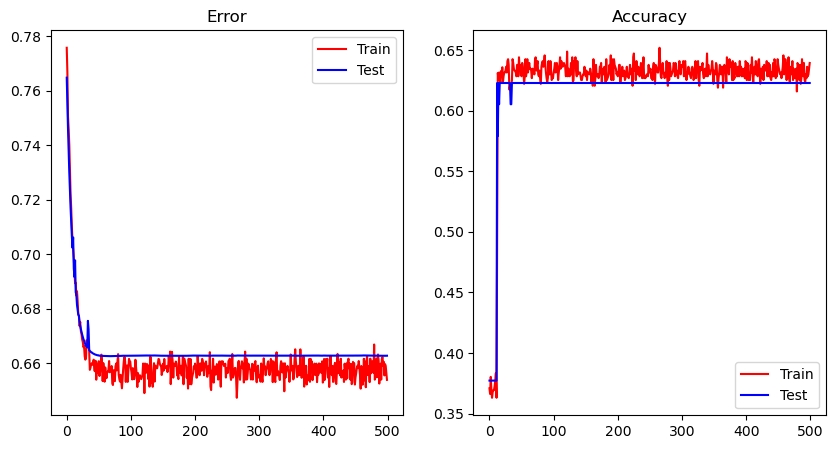

In [7]:
# Step 4: Visualise model performance using error and accuracy
    
# Training/Testing Error graph plot
epochs_range = np.arange(epochs)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_errors, label="Train", color='red')
plt.plot(epochs_range, test_errors, label="Test", color='blue')
plt.legend(loc='best')
plt.title('Error')

# Training/Testing Accuracy graph plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label="Train", color='red')
plt.plot(epochs_range, test_accuracy, label="Test", color='blue')
plt.legend(loc='best')
plt.title('Accuracy')

plt.show()

### Printing Model Statistics:
- Prints the initial and final training and testing errors and accuracies.

In [8]:
import pandas as pd

# Print baseline model statistics
# Define the training and testing stats dictionaries
training_stats = {
    'Metric': ['First Error', 'Final Error', 'First Accuracy', 'Final Accuracy'],
    'Value': [train_errors[0], train_errors[-1], train_accuracy[0], train_accuracy[-1]]
}

testing_stats = {
    'Metric': ['First Error', 'Final Error', 'First Accuracy', 'Final Accuracy'],
    'Value': [test_errors[0], test_errors[-1], test_accuracy[0], test_accuracy[-1]]
}

# Create DataFrames
training_df = pd.DataFrame(training_stats)
testing_df = pd.DataFrame(testing_stats)

# Print DataFrames
print("Training Stats:")
print(training_df)
print("\nTesting Stats:")
print(testing_df)

Training Stats:
           Metric     Value
0     First Error  0.775753
1     Final Error  0.653976
2  First Accuracy  0.370846
3  Final Accuracy  0.639332

Testing Stats:
           Metric     Value
0     First Error  0.764798
1     Final Error  0.662842
2  First Accuracy  0.377193
3  Final Accuracy  0.622807
